### Using the preprocessed data, this notebook produces plots of the sea surface temperature decomposition and maps of marine heatwave summary statistics.

In [2]:
# Data analysis libraries 
import s3fs
import sys
import xarray as xr
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Download cpt files from zenodo (https://zenodo.org/record/3703160#.YRFm3xNKhqs) and add it to your path
sys.path.append('/burg/home/hs3277/jupiter_data_science/getcpt-master')
import get_cpt 


#### Load data and assign variables

In [11]:
ds_new = xr.open_dataset('/burg/home/hs3277/jupiter_data_science/data/preprocessed_oisst_mhw_stats.nc')

seas = ds_new.seas
mean = ds_new['mean']
trend = ds_new.trend
ssta_notrend = ds_new.ssta_notrend

In [22]:
endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},) 

path = "Pangeo/pangeo-forge/noaa_oisst/v2.1-avhrr.zarr"
ds = xr.open_zarr(fs_osn.get_mapper(path), consolidated=True).resample(time='MS').mean()
sst = ds.sst.isel(zlev=0).drop('zlev')
sst.load();

/burg/home/hs3277/.conda/envs/marine-heatwaves/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


---
### 01_Plot SST time series decomposition at a single point

![fig](../static/figure_01.png)



In [25]:
# location of time series
lon=211.125 
lat=46.625 

point_sst = sst.loc[dict(lon=lon, lat=lat)]
point_seas = seas.loc[dict(lon=lon, lat=lat)]
point_mean = mean.loc[dict(lon=lon, lat=lat)]
point_trend = trend.loc[dict(lon=lon, lat=lat)]
point_variability = ssta_notrend.loc[dict(lon=lon, lat=lat)]
t90 = point_variability.quantile(.9)

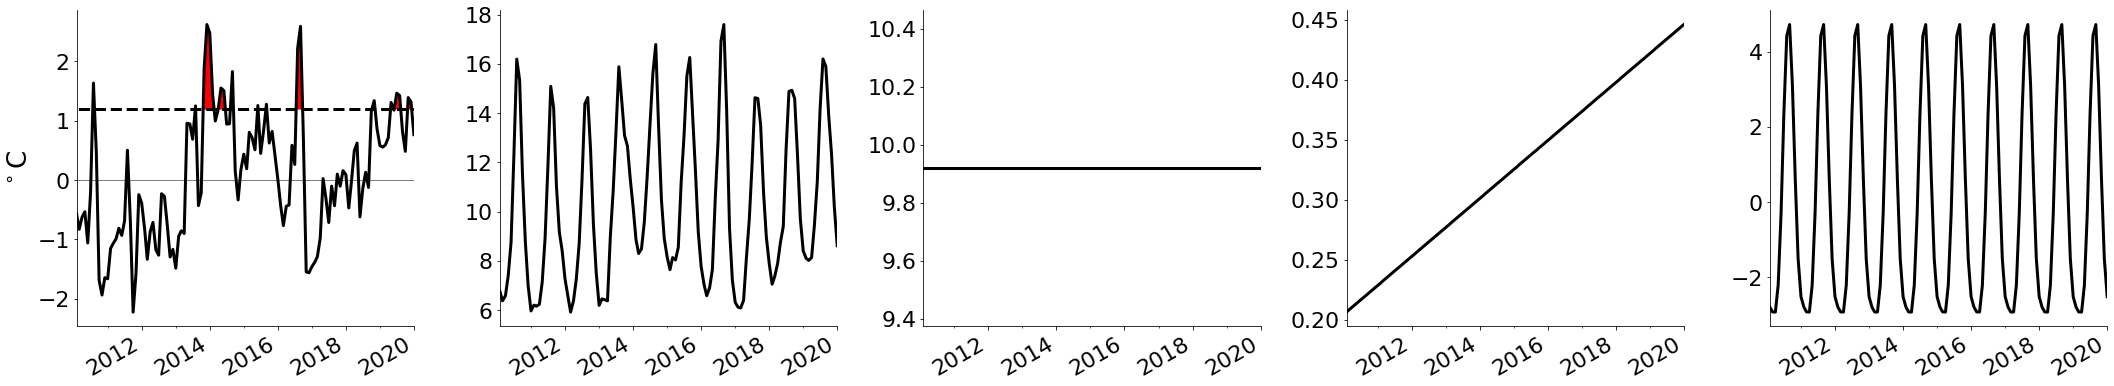

In [32]:
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
fig = plt.figure(figsize=(30,6)) 

c = 'k'; # choose white for presentation

# variability
ax = plt.subplot(151)
point_variability.sel(time=slice('02-01-2010','01-01-2020')).plot(c=c, lw=3)
plt.plot(point_variability.time, np.ones(point_variability.time.shape[0])*t90.values,'--', color='k',lw=3)
plt.fill_between(point_variability.time, t90.values, point_variability.values, 
                 where=point_variability.values>=t90.values, interpolate=True, color='r')
plt.axhline(y=0, color=c, lw=1, alpha=0.5)
plt.title(''); plt.xlabel(''); plt.ylabel(r"$^\circ$C", fontsize=26)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
# ax.yaxis.label.set_color('w')      
# ax.tick_params(axis='x', colors='w')    
# ax.tick_params(axis='y', colors='w')  
# ax.spines['left'].set_color('w')       
# ax.spines['top'].set_color('w')
# ax.spines['bottom'].set_color('w')
plt.xlim(point_mean.sel(time = '02-01-2010').time, point_mean.sel(time ='01-01-2020').time)

# sst or mean
ax = plt.subplot(152)
sst.loc[dict(lon=lon, lat=lat)].sel(time=slice('02-01-2010','01-01-2020')).plot(c=c, lw=3)
# point_mean.sel(time=slice('02-01-2010','01-01-2020')).plot(c='w', lw=3)
plt.title(''); plt.xlabel(''); plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
# ax.yaxis.label.set_color('w')      
# ax.tick_params(axis='x', colors='w')    
# ax.tick_params(axis='y', colors='w')  
# ax.spines['left'].set_color('w')       
# ax.spines['top'].set_color('w') 
# ax.spines['bottom'].set_color('w')
plt.xlim(point_mean.sel(time = '02-01-2010').time, point_mean.sel(time ='01-01-2020').time)

# mean
ax = plt.subplot(153)
point_mean.sel(time=slice('02-01-2010','01-01-2020')).plot(c=c, lw=3)
plt.title(''); plt.xlabel(''); plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
# ax.yaxis.label.set_color('w')      
# ax.tick_params(axis='x', colors='w')    
# ax.tick_params(axis='y', colors='w')  
# ax.spines['left'].set_color('w')       
# ax.spines['top'].set_color('w') 
# ax.spines['bottom'].set_color('w')
plt.xlim(point_mean.sel(time = '02-01-2010').time, point_mean.sel(time ='01-01-2020').time)


# trend
ax = plt.subplot(154)
point_trend.sel(time=slice('02-01-2010','01-01-2020')).plot(c=c, lw=3)
plt.title(''); plt.xlabel(''); plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
# ax.yaxis.label.set_color('w')      
# ax.tick_params(axis='x', colors='w')    
# ax.tick_params(axis='y', colors='w')  
# ax.spines['left'].set_color('w')       
# ax.spines['top'].set_color('w')
# ax.spines['bottom'].set_color('w')
plt.xlim(point_mean.sel(time = '02-01-2010').time, point_mean.sel(time ='01-01-2020').time)

# seasonal cycle
ax = plt.subplot(155)
point_seas.sel(time=slice('02-01-2010','01-01-2020')).plot(c=c, lw=3)
plt.title(''); plt.xlabel(''); plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
# ax.yaxis.label.set_color('w')      
# ax.tick_params(axis='x', colors='w')    
# ax.tick_params(axis='y', colors='w')  
# ax.spines['left'].set_color('w')       
# ax.spines['top'].set_color('w')
# ax.spines['bottom'].set_color('w')
plt.xlim(point_mean.sel(time = '02-01-2010').time, point_mean.sel(time ='01-01-2020').time)


fig.tight_layout(pad=3.0)

plt.savefig('figure_X.png', transparent=True)


---
### 02_Plot map with location marker

![fig](../static/figure_02.png)

In [ ]:
fig = plt.figure(figsize=(10,5)) 
ax = plt.subplot(111, projection=ccrs.Robinson(central_longitude=200))
plt.plot(lon, lat, '*', ms=32, markerfacecolor='magenta', markeredgecolor='k', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='w', zorder=1) 
ax.set_global()

# plt.savefig('figure_02.png', transparent=True)

---
### 03_Plot kernel density estimation

![fig](../static/figure_03.png)

In [ ]:
x = point_variability.values
x_d = np.linspace(point_variability.min().values, point_variability.max().values, 1000)

#Selecting the bandwidth via cross-validation
bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(x[:, None]);

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=grid.best_params_['bandwidth'], kernel='gaussian')
kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])


threshold = point_variability.quantile(.9, dim=('time'))
I = np.where(x_d>=threshold.values) # find where SSTA exceeds the threshold

height = -1* ((np.exp(logprob)).max() - (np.exp(logprob)).min()) / 40 # height for ticks at bottom of plot


In [ ]:
plt.rc('xtick', labelsize=24) 
plt.rc('ytick', labelsize=24)
fig = plt.figure(figsize=(10,7)) 

ax = plt.subplot(111)
plt.fill_between(x_d, np.exp(logprob), alpha=1, color='lightgray')
plt.plot(x, np.full_like(x, height), '|k', markeredgewidth=2)
plt.axvline(x=threshold.values, linestyle='--', lw=6, color='darkcyan')
plt.fill_between(x_d[I], np.exp(logprob[I]), color='red')
plt.xlabel(r'SSTA $^{\circ}$C', fontsize=26, color='w')
plt.ylabel('PDF', fontsize=26, color='w')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.label.set_color('w')      
ax.tick_params(axis='x', colors='w')    
ax.tick_params(axis='y', colors='w')  
ax.spines['left'].set_color('w')       
ax.spines['bottom'].set_color('w')
# plt.savefig('figure_03.png', transparent=True)

---
### 04_Plot marine heatwave identification from time series
![fig](../static/figure_04.png)


In [ ]:
t90 = point_variability.quantile(.9)

In [ ]:
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
fig = plt.figure(figsize=(10,6)) 

c = 'k' # Set to white for presentation

ax = plt.subplot(111)
point_variability.sel(time=slice('02-01-2010','01-01-2020')).plot(c=c, lw=3)
plt.plot(point_variability.time, np.ones(point_variability.time.shape[0])*t90.values,'--', color='darkcyan',lw=3)
plt.fill_between(point_variability.time, t90.values, point_variability.values, 
                 where=point_variability.values>=t90.values, interpolate=True, color='r')
plt.axhline(y=0, color=c, lw=1, alpha=0.5)
plt.title(''); plt.ylabel(r"$\rm SST'$ ($\rm ^{\circ}C$)", color=c, fontsize=22); plt.xlabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
ax.yaxis.label.set_color('w')      
ax.tick_params(axis='x', colors='w')    
ax.tick_params(axis='y', colors='w')  
ax.spines['left'].set_color('w')       
ax.spines['top'].set_color('w')
ax.spines['bottom'].set_color('w')
plt.xlim(point_mean.sel(time = '02-01-2010').time, point_mean.sel(time ='01-01-2020').time)

fig.tight_layout(pad=3.0)

# plt.savefig('figure_04.png', transparent=True, dpi=600)

---
### 05_Plot map of SST climatology 

![fig](../static/figure_05.png)


In [ ]:
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
fig = plt.figure(figsize=(20,10)) 

ax = plt.subplot(111, projection=ccrs.Robinson(central_longitude=200))
ax.add_feature(cfeature.LAND, facecolor='k', zorder=1) 
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.coastlines(resolution='50m', color='black', linewidth=1)
cont = mean.isel(time=0).plot.pcolormesh(vmin=0, vmax=30, levels=np.arange(0,32,2),
                                                     cmap=get_cpt.get_cmap('/burg/home/hs3277/getcpt-master/cpt/temperature.cpt'), 
                                                     extend='both',
                                                     transform=ccrs.PlateCarree(), zorder=0,
                                                     add_labels=False, add_colorbar=False,
                                                    )
cbar = plt.colorbar(cont, fraction=0.022, pad=0.04)
cbar.set_label(r"$\rm^{\circ}C$", color='w', fontsize=40)
cbar.outline.set_edgecolor('k')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='w')
cbar.ax.yaxis.set_tick_params(color='w')
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.tick_params(which='major', width=1.3, length=7)
ax.tick_params(which='minor', width=1, length=4)
ax.set_global()

# plt.savefig('figure_05.png', transparent=True)


---
### 06_Plot map of SST trend

![fig](../static/figure_06.png)

In [ ]:
T = trend + mean
T = T.sel(time=slice('1990-01-01','2020-12-01')) # trend over 30-years
trend_slope = T[-1,:,:]-T[0,:,:]

# Make figure 
fig = plt.figure(figsize=(20,10)) 

ax = plt.subplot(111, projection=ccrs.Robinson(central_longitude=200))
ax.add_feature(cfeature.LAND, facecolor='k', zorder=1) 
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.coastlines(resolution='50m', color='black', linewidth=1)
cont = trend_slope.plot.pcolormesh(vmin=-2, vmax=2, levels=np.arange(-2,2.2,.2),
                                   cmap= get_cpt.get_cmap('/burg/home/hs3277/getcpt-master/cpt/GMT_panoply.cpt'), 
                                   extend='both', transform=ccrs.PlateCarree(), 
                                   zorder=0, add_labels=False, add_colorbar=False)
cbar = plt.colorbar(cont, fraction=0.022, pad=0.04)
cbar.set_label(r"$\rm^{\circ}$C per 30-years", fontsize=40, color='w')
cbar.outline.set_edgecolor('k')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='w')
cbar.ax.yaxis.set_tick_params(color='w')
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.tick_params(which='major', width=1.3, length=7)
ax.tick_params(which='minor', width=1, length=4)
ax.set_global()

# plt.savefig('figure_06.png', transparent=True)


---
### 07_Plot map of SST seasonal cycle amplitude

![fig](../static/figure_07.png)

In [ ]:
# Seasonal cycle amplitude
S = seas + mean
seas_amp = S.max('time') - S.min('time')

# Make figure 
fig = plt.figure(figsize=(20,10)) 

ax = plt.subplot(111, projection=ccrs.Robinson(central_longitude=200))
ax.add_feature(cfeature.LAND, facecolor='k', zorder=1) 
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.coastlines(resolution='50m', color='black', linewidth=1)
cont = seas_amp.plot.pcolormesh(vmin=0, vmax=20, levels=np.arange(0,17,1),
                                cmap= get_cpt.get_cmap('/burg/home/hs3277/getcpt-master/cpt/precip2_17lev.cpt'), 
                                extend='max', transform=ccrs.PlateCarree(), 
                                zorder=0, add_labels=False, add_colorbar=False,
                               )
cbar = plt.colorbar(cont, fraction=0.022, pad=0.04)
cbar.set_label(r"$\rm^{\circ}C$", fontsize=40, color='w')
cbar.outline.set_edgecolor('k')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='w')
cbar.ax.yaxis.set_tick_params(color='w')
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.tick_params(which='major', width=1.3, length=7)
ax.tick_params(which='minor', width=1, length=4)
ax.set_global()

# plt.savefig('figure_07.png', transparent=True)


---
### 08_Plot map of SST standard deviation

![fig](../static/figure_08.png)

In [ ]:
# Standard deviation of detrended SSTA 
stdev_global = ssta_notrend.std('time')

# Make figure 
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
fig = plt.figure(figsize=(20,10)) 

ax = plt.subplot(111, projection=ccrs.Robinson(central_longitude=200))
ax.add_feature(cfeature.LAND, facecolor='k', zorder=1) 
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.coastlines(resolution='50m', color='black', linewidth=1)
# lon=144.125 ; lat=12.625 
# plt.plot(lon, lat, '*', ms=45, markerfacecolor='magenta', markeredgecolor='k', transform=ccrs.PlateCarree(), zorder=0)
# lon=250.125; lat=0.125
# plt.plot(lon, lat, '*', ms=45, markerfacecolor='magenta', markeredgecolor='k', transform=ccrs.PlateCarree(), zorder=0)
cont = stdev_global.plot.pcolormesh(vmin=0, vmax=1.4, levels=np.arange(0,1.5,.1),
                                    cmap= get_cpt.get_cmap('/burg/home/hs3277/getcpt-master/cpt/seminf-haxby.cpt'), 
                                    extend='max', transform=ccrs.PlateCarree(), 
                                    zorder=0, add_labels=False, add_colorbar=False,
                                   )
cbar = plt.colorbar(cont, fraction=0.022, pad=0.04)
cbar.set_label(r"$\rm^{\circ}C$", fontsize=40, color='w')
cbar.outline.set_edgecolor('k')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='w')
cbar.ax.yaxis.set_tick_params(color='w')
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.tick_params(which='major', width=1.3, length=7)
ax.tick_params(which='minor', width=1, length=4)
ax.set_global()

# plt.savefig('figure_08.png', transparent=True)


---
### 09_Plot map of average marine heatwave duration

![fig](../static/figure_09.png)

In [ ]:
# Average Duration
plt.rc('xtick', labelsize=26) 
plt.rc('ytick', labelsize=26)
fig = plt.figure(figsize=(20,10)) 

c='k' # Set to white for presentation
ax = plt.subplot(111, projection=ccrs.Robinson(central_longitude=200))
ax.add_feature(cfeature.LAND, facecolor='k', zorder=1) 
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.coastlines(resolution='50m', color='black', linewidth=1)
cont = ds_new.avg_duration.plot.contourf(vmin=1, vmax=5, levels=np.arange(1,6,1),
                                   cmap= get_cpt.get_cmap('/burg/home/hs3277/getcpt-master/cpt/YlOrRd_09.cpt'), 
                                   extend='both', transform=ccrs.PlateCarree(), 
                                   zorder=0, add_labels=False, add_colorbar=False)
cbar = plt.colorbar(cont, fraction=0.022, pad=0.04)
cbar.set_label(r"Average Duration (months)", fontsize=30, color=c)
cbar.outline.set_edgecolor('k')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=c)
cbar.ax.yaxis.set_tick_params(color=c)

ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.tick_params(which='major', width=1.3, length=7)
ax.tick_params(which='minor', width=1, length=4)
ax.set_global()

# plt.savefig('figure_09.png', transparent=True)


---
### 10_Plot map of total marine heatwave event count

![fig](../static/figure_10.png)

In [ ]:
# Total Count
plt.rc('xtick', labelsize=32) 
plt.rc('ytick', labelsize=32)
fig = plt.figure(figsize=(20,10)) 

c='k' # Set to white for presentation
ax = plt.subplot(111, projection=ccrs.Robinson(central_longitude=200))
ax.add_feature(cfeature.LAND, facecolor='k', zorder=1) 
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.coastlines(resolution='50m', color='black', linewidth=1)
cont = ds_new.avg_count.plot.contourf(vmin=0, vmax=80, levels=np.arange(0,90,10),
                                   cmap= get_cpt.get_cmap('/burg/home/hs3277/getcpt-master/cpt/YlOrRd_09.cpt'), 
                                   extend='max', transform=ccrs.PlateCarree(), 
                                   zorder=0, add_labels=False, add_colorbar=False)
cbar = plt.colorbar(cont, fraction=0.022, pad=0.04)
cbar.set_label(r"# events", fontsize=36, color=c)
cbar.outline.set_edgecolor('k')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=c)
cbar.ax.yaxis.set_tick_params(color=c)

ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.tick_params(which='major', width=1.3, length=7)
ax.tick_params(which='minor', width=1, length=4)
ax.set_global()

# plt.savefig('figure_10.png', transparent=True)

---
### 11_Plot map of average marine heatwave intensity

![fig](../static/figure_11.png)

In [ ]:
# Average Intensity
plt.rc('xtick', labelsize=32) 
plt.rc('ytick', labelsize=32)
fig = plt.figure(figsize=(20,10)) 

c='k' # Set to white for presentation
ax = plt.subplot(111, projection=ccrs.Robinson(central_longitude=200))
ax.add_feature(cfeature.LAND, facecolor='k', zorder=1) 
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.coastlines(resolution='50m', color='black', linewidth=1)
cont = ds_out.avg_intensity.plot.contourf(vmin=0.4, vmax=1.8, levels=np.arange(0.4,2,.2),
                                   cmap= get_cpt.get_cmap('/burg/home/hs3277/getcpt-master/cpt/YlOrRd_09.cpt'), 
                                   extend='both', transform=ccrs.PlateCarree(), 
                                   zorder=0, add_labels=False, add_colorbar=False)
cbar = plt.colorbar(cont, fraction=0.022, pad=0.04)
cbar.set_label(r"$\rm^{\circ}C$", fontsize=36, color=c)
cbar.outline.set_edgecolor('k')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=c)
cbar.ax.yaxis.set_tick_params(color=c)

ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.tick_params(which='major', width=1.3, length=7)
ax.tick_params(which='minor', width=1, length=4)
ax.set_global()

# plt.savefig('figure_11.png', transparent=True)
